In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy.optimize import curve_fit

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [8]:

with open(DATAFOLDER / "bazzino_data_with_clusters_and_dists.pickle", "rb") as f:
    data = dill.load(f)
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]
pca = data["pca"]

with open(DATAFOLDER / "sigmoidal_fits.pickle", "rb") as f:
    fits = dill.load(f)

fits_df_cluster_raw = fits["fits_df_cluster_raw"]
fits_df_clusterness = fits["fits_df_clusterness"]
fits_df_euclidean = fits["fits_df_euclidean"]

In [23]:
def realigned_trials(x_array, fits, verbose=True):

# Realigning behavioral data to dopamine transitions
    realigned_trials = []

    for rat in x_array.id.unique():
        
        x_array_r = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'")

        if rat not in fits.id.unique():
            if verbose:
                print(f"Rat {rat} not found in fitted parameters, skipping.")
            realigned_trials.append([np.nan] * len(x_array_r.trial))
        else:
            transition_point = int(fits.query("id == @rat").x0_orig.values[0])
            realigned_trials.append(x_array_r.trial - transition_point)

    return (
        x_array
        .assign(trial_aligned=tp.flatten_list(realigned_trials))
        .dropna()
        .reset_index(drop=True)
        # .astype(int)  # Ensure the trial_aligned column is of integer type
        )
    
        
        # Update the original DataFrame
        # print(len(x_array.loc[x_array.id == rat, 'trial_aligned']))
        # x_array.loc[x_array.id == rat, 'trial_aligned'] = x_array_r['trial_aligned'].values
df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

z = realigned_trials(df2_dep_45, fits_df_clusterness)

Rat PB27 not found in fitted parameters, skipping.


In [24]:
z

,trial,id,condition,infusiontype,cluster_photo,cluster_vel,auc_snips,auc_vel,clusterness_photo,euclidean_diff,trial_aligned
0,0,PB26,deplete,45NaCl,0,1,1.751713,-3.778940,0.644916,0.876384,-23.0
1,1,PB26,deplete,45NaCl,0,1,1.606179,-3.247381,0.619632,0.823733,-22.0
2,2,PB26,deplete,45NaCl,0,1,0.864692,-3.587596,0.616186,1.163286,-21.0
3,3,PB26,deplete,45NaCl,0,1,0.995948,-2.667890,0.561951,0.631847,-20.0
4,4,PB26,deplete,45NaCl,0,1,1.563953,-3.042829,0.579108,0.537403,-19.0
...,...,...,...,...,...,...,...,...,...,...,...
436,44,PB75,deplete,45NaCl,1,1,-0.201180,3.736886,0.408037,-1.212506,15.0
437,45,PB75,deplete,45NaCl,1,0,-0.544147,4.750915,0.352093,-1.396677,16.0
438,46,PB75,deplete,45NaCl,1,0,-0.045962,3.688128,0.458332,-0.510602,17.0
439,47,PB75,deplete,45NaCl,1,1,-0.197668,1.650328,0.386716,-1.312865,18.0


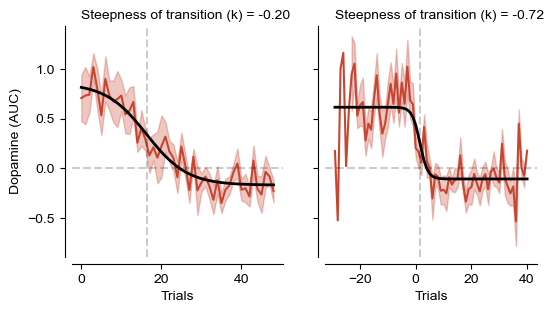

In [25]:
# make dopamine figure with trials and sigmoidal fit

def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3])
    ax.fill_between(x, y-sem, y+sem, color=colors[3], alpha=0.3)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color="k", lw=2)
        if include_steepness:
            ax.text(first_trial, 1.5, "Steepness of transition (k) = {:.2f}".format(popt[2]))
    except:
        print("Failed to fit")

    ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(popt[1], color="k", linestyle="--", alpha=0.2)
    sns.despine(ax=ax, offset=5)

    ax.set_ylabel("Dopamine (AUC)")
    ax.set_xlabel("Trials")


f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0])
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min())

ax[1].set_ylabel("")

if savefigs:
    f.savefig(FIGSFOLDER / "realigned_transitions.png")



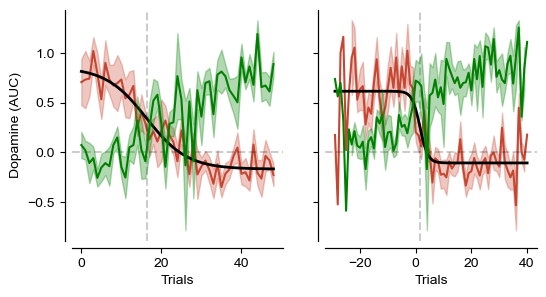

In [26]:
def plot_realigned_behaviour(df, column, ax=None, first_trial=0):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_vel
    sd = df.groupby(column).std(numeric_only=True).auc_vel.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color="green")
    ax.fill_between(x, y-sem, y+sem, color="green", alpha=0.3)
    
    sns.despine(ax=ax, offset=5)
    ax.set_yticks([])

    # ax.set_ylabel("Dopamine (AUC)")
    # ax.set_xlabel("Trials")

f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0], include_steepness=False)
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min(), include_steepness=False)

ax[1].set_ylabel("")

ax2 = ax[0].twinx()
plot_realigned_behaviour(z, "trial",ax=ax2)
f.savefig(FIGSFOLDER / "realigned_transitions_behav1.png")

ax3 = ax[1].twinx()
plot_realigned_behaviour(z, "trial_aligned",ax=ax3, first_trial=z.trial_aligned.min())
f.savefig(FIGSFOLDER / "realigned_transitions_behav2.png")
    

In [27]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column):
    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

real_k = fit_sigmoid(z, "trial_aligned")[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = fits_df_clusterness.x0_orig.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = fits_df_clusterness.assign(x0_orig=shuffled_x0s)
    z_temp = realigned_trials(df2_dep_45, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned")[2]

print(real_k)



c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


-0.7229482448276218


Text(0.5, 0, 'Steepness of transition (k)')

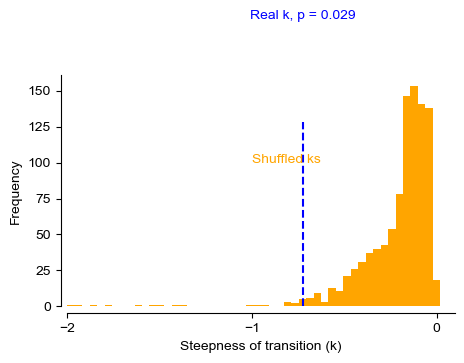

In [28]:
color_shuf = "orange"
color_real = "blue"

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k, 200,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k > real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [29]:
# to calculate difference before and after to see whether realigning worked

transition = 0
before = z.query("trial_aligned < @transition").auc_vel.mean()
after = z.query("trial_aligned >= @transition").auc_vel.mean()
print(f"Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

Before transition: -1.86, After transition: 0.88, Difference: 2.74


In [30]:
for transition in np.arange(1, 48):
    before = z.query("trial < @transition").auc_vel.mean()
    after = z.query("trial >= @transition").auc_vel.mean()
    print(f"{transition}, Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

1, Before transition: -1.56, After transition: -0.06, Difference: 1.50
2, Before transition: -1.69, After transition: -0.02, Difference: 1.67
3, Before transition: -1.96, After transition: 0.03, Difference: 1.99
4, Before transition: -2.04, After transition: 0.08, Difference: 2.12
5, Before transition: -2.29, After transition: 0.16, Difference: 2.44
6, Before transition: -2.36, After transition: 0.22, Difference: 2.59
7, Before transition: -2.39, After transition: 0.29, Difference: 2.68
8, Before transition: -2.42, After transition: 0.36, Difference: 2.78
9, Before transition: -2.33, After transition: 0.41, Difference: 2.74
10, Before transition: -2.21, After transition: 0.45, Difference: 2.66
11, Before transition: -2.25, After transition: 0.53, Difference: 2.79
12, Before transition: -2.34, After transition: 0.64, Difference: 2.98
13, Before transition: -2.29, After transition: 0.70, Difference: 2.99
14, Before transition: -2.24, After transition: 0.77, Difference: 3.00
15, Before tr